In [37]:
import numpy as np 
import pandas as pd 
import random


import os
import glob


from PIL import Image


import matplotlib.pyplot as plt
plt.rc('image', cmap='hsv')


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#tensorflow

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [38]:
categories = ["NORMAL", "PNEUMONIA"]
datasets = ["train", "test", "val"]

In [39]:
#glob.glob('C:\\Users\\김주빈\\project\\Damion\\project\\Chest X-Ray Images (Pneumonia)\\chest_xray\\*')

In [40]:
%%time

data = []
target = []

for set_ in datasets:
    for cat in categories:
        filelist = glob.glob('C:\\Users\\김주빈\\chest_xray\\'+ set_ + '/' + cat + '/*.jpeg')
        target.extend([cat for _ in filelist])
        data.extend([np.array(Image.open(fname).convert('RGB').resize((150, 150))) for fname in filelist])
#
data_array = np.stack(data, axis=0)
target = np.array(target)

Wall time: 1min 24s


In [41]:
print(data_array.shape)
print(target)

(5856, 150, 150, 3)
['NORMAL' 'NORMAL' 'NORMAL' ... 'PNEUMONIA' 'PNEUMONIA' 'PNEUMONIA']


In [42]:
X_train, X_test, y_train, y_test = train_test_split(data_array, target, random_state = 43, test_size = 0.2, stratify=target)

In [43]:
print(X_train.shape)
print(y_train.shape)

(4684, 150, 150, 3)
(4684,)


In [44]:
pd.DataFrame(y_train).value_counts()/len(y_train)
pd.DataFrame().value_counts()/len(y_train)

Series([], dtype: float64)

In [45]:
#정규화 (0에서 1까지 픽셀값 조정)
#X_test_norm = np.round((X_test/255), 3).copy()
#X_train_norm = np.round((X_train/255), 3).copy()

In [46]:
encoder = LabelEncoder()

In [47]:
y_train_cat = encoder.fit_transform(y_train)
y_test_cat = encoder.fit_transform(y_test)

In [48]:
print(y_train[:3])
print(y_train_cat[:3])

['PNEUMONIA' 'NORMAL' 'NORMAL']
[1 0 0]


In [49]:
X_train_norm = X_train.reshape(-1, 150, 150, 3)
X_test_norm = X_test.reshape(-1, 150, 150, 3)
X_train_norm.shape

(4684, 150, 150, 3)

In [58]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model

def Xception_model():
    model = Xception(input_shape = (150,150,3), weights='imagenet',include_top=False)
    for layer in model.layers:
          layer.trainable = False
    
    x = layers.Flatten()(model.output)
    x = layers.Dense(1000, activation='relu')(x)
    y = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs=model.input, outputs=y)

    return model

In [59]:
def compile_model(model):
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics="accuracy")
    return model

In [ ]:
model = Xception_model()
model = compile_model(model)
es = EarlyStopping(patience=15, monitor='val_accuracy', restore_best_weights=True)

history = model.fit(X_train_norm, y_train_cat,
                    batch_size=25,
                    epochs=5,
                    validation_split=0.3,
                    callbacks=[es])

for layer in model.layers[:-2]:
          layer.trainable = True


optimizer = tf.keras.optimizers.Adam(lr=1e-5)
model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics="accuracy")
history = model.fit(X_train_norm, y_train_cat,
                    batch_size=32,
                    epochs=5,
                    validation_split=0.3,
                    callbacks=[es])


Epoch 1/5
132/132 [==============================] - 10s 75ms/step - loss: 61.5078 - accuracy: 0.8551 - val_loss: 22.6799 - val_accuracy: 0.8506
Epoch 2/5
132/132 [==============================] - 9s 70ms/step - loss: 8.2325 - accuracy: 0.9124 - val_loss: 6.7372 - val_accuracy: 0.9139
Epoch 3/5
132/132 [==============================] - 9s 69ms/step - loss: 6.1230 - accuracy: 0.9131 - val_loss: 39.2288 - val_accuracy: 0.6053
Epoch 4/5
132/132 [==============================] - 9s 70ms/step - loss: 8.8560 - accuracy: 0.8948 - val_loss: 4.8054 - val_accuracy: 0.9310
Epoch 5/5
132/132 [==============================] - 9s 69ms/step - loss: 1.8780 - accuracy: 0.9478 - val_loss: 3.7080 - val_accuracy: 0.8883
Epoch 1/5
103/103 [==============================] - 31s 297ms/step - loss: 0.5176 - accuracy: 0.8456 - val_loss: 0.3767 - val_accuracy: 0.8478
Epoch 2/5
103/103 [==============================] - 29s 280ms/step - loss: 0.1634 - accuracy: 0.9402 - val_loss: 0.1652 - val_accuracy: 0.936

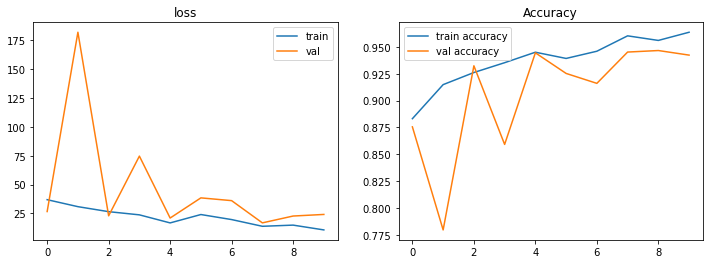

In [42]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(-0.1, 0.1)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.9, 1.1)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

plot_history(history, title='', axs=None, exp_name="");

In [43]:
model.evaluate(X_test_norm, y_test_cat, verbose=0)

[23.980209350585938, 0.9462457299232483]

In [33]:
predictions = model.predict(X_test_norm)
print(predictions)

[[9.9953198e-01]
 [9.9999964e-01]
 [9.9999475e-01]
 ...
 [6.3517690e-04]
 [3.4366548e-03]
 [1.0000000e+00]]


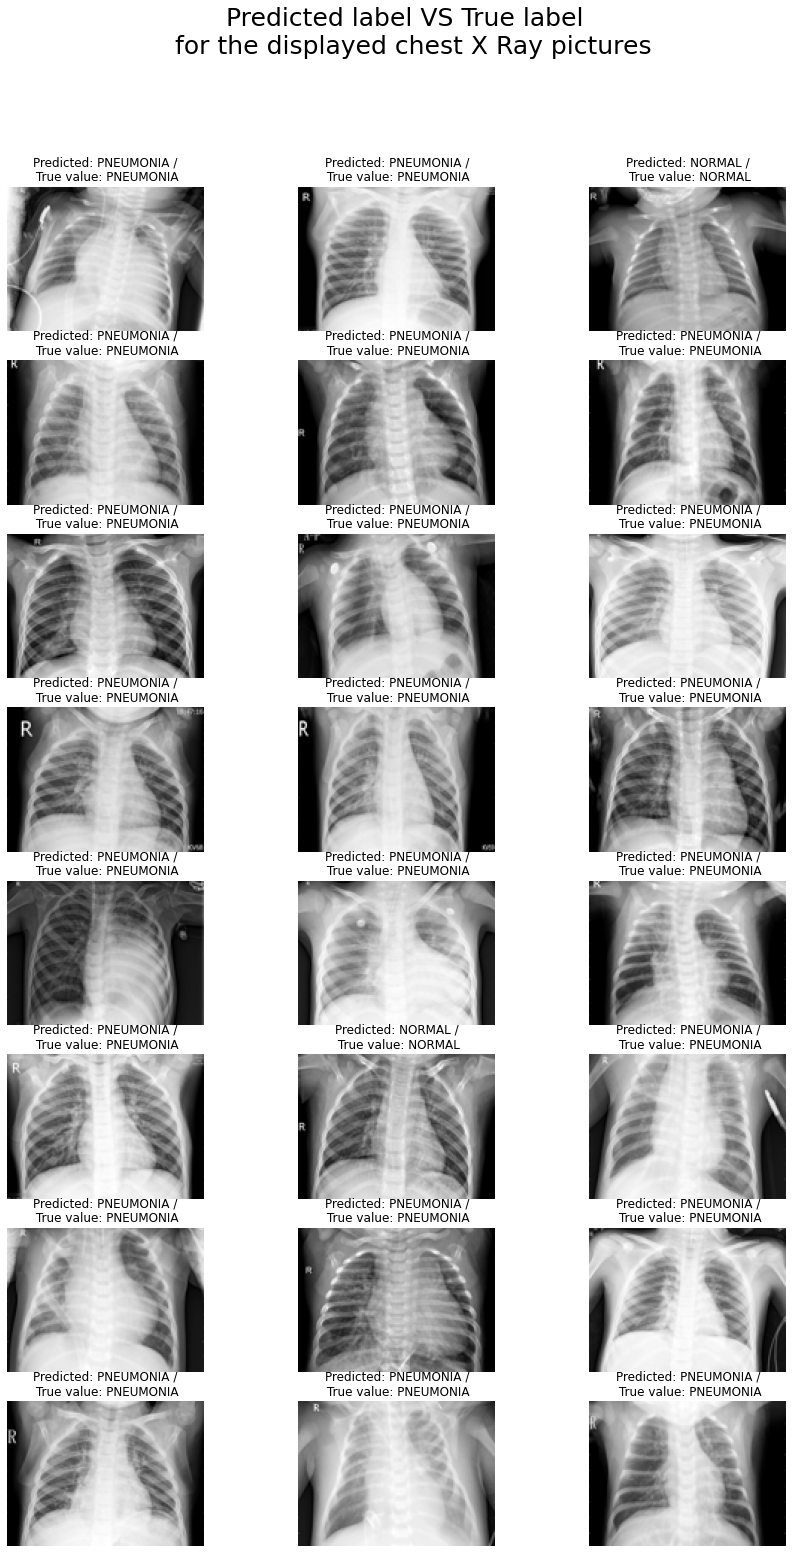

In [32]:
fig = plt.figure(figsize=(20,25))
gs = fig.add_gridspec(8, 4)
#
for row in range(0, 8):
    for col in range(0, 3):
        num_image = random.randint(0, X_test_norm.shape[0])
        ax = fig.add_subplot(gs[row, col])
        ax.axis('off');
        ax.set_title("Predicted: " + categories[int(np.round(predictions)[num_image][0])] + " /\n True value: " + categories[y_test_cat[num_image]])
        ax.imshow(X_test_norm[num_image]);
fig.suptitle("Predicted label VS True label \n for the displayed chest X Ray pictures", fontsize=25, x=0.42);
#plt.tight_layout;
